# ABOUT
- this notebook compare performances of difference recommender models

In [1]:
from models import ALSRecommender, PopRecommender
from evaluation import evaluate
from processing import *
from utils import IDMAP
import pandas as pd
import seaborn as sb

C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### process

In [2]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\data\Ratings.csv\Ratings.csv"
data = pd.read_csv(path)

# remove samples with less than minimum_interaction
processed_data = filter_by_num_interactions(data, "User-ID", "ISBN", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "ISBN", "User-ID", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "User-ID", "ISBN", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "ISBN", "User-ID", minimum_interaction = 10)
# add column containing all ones
processed_data = add_interaction_column(processed_data)
# train_test_split
train, test = train_test_split(processed_data, train_frac = 0.7, seed = 0)
# convert to csr interaction matrix i.e input to model
train_csr, users, items = df2interact_mat(df = train, user_col = 'User-ID', item_col = "ISBN", interact_col = "interaction")
# retain a mapping between userids, itemids and their indexes in the recommender model
user_map = IDMAP(users)
item_map = IDMAP(items)

In [26]:
model_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\code\models\test0"
hyperparameters = {
    "AlternatingLeastSquares":{
        "factors":64, 
        "regularization":0.01, 
        "alpha":1.0, 
        "iterations" : 20,
        "random_state":0
    },
    "BayesianPersonalizedRanking":{
        "factors":64, 
        "learning_rate":0.01,
        "regularization":0.01, 
        "verify_negative_samples":True, 
        "iterations" : 100,
        "random_state":0
    },
    "LogisticMatrixFactorization":{
        "factors":64, 
        "learning_rate":1.0,
        "regularization":0.6,
        "neg_prop":30,
        "iterations" : 100,
        "random_state":0
    }
}

## Compare model performances

In [27]:
results = {}
for model_name, config in hyperparameters.items():
    # train on training set
    model = ALSRecommender(model_name, hyperparameters[model_name], train_csr, user_map, item_map)
    model.fit()
    # evaluate on test set
    results[model_name] = evaluate(model, test)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1266.29it/s]


In [28]:
# evaluate popularity recommender
pop = PopRecommender()
pop.fit(train)
results["pop"] = evaluate(pop, test)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.75it/s]


In [32]:
results

{'AlternatingLeastSquares': 0.06067553661934336,
 'BayesianPersonalizedRanking': 0.04531306398253903,
 'LogisticMatrixFactorization': 0.03529014021898207,
 'pop': 0.005180579675589556}

<AxesSubplot:>

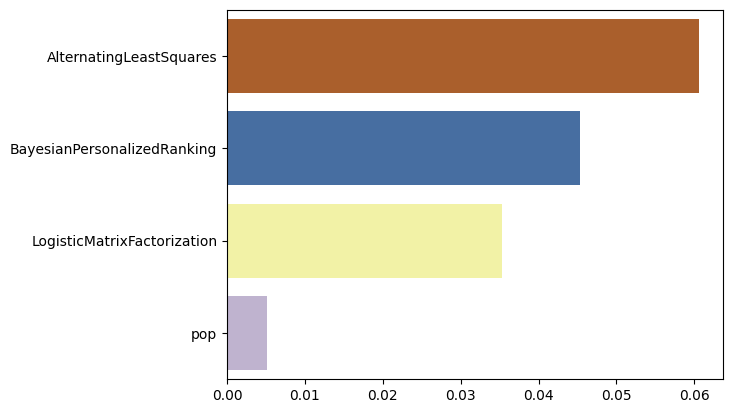

In [39]:
sb.barplot(y = list(results.keys()), x =  list(results.values()), palette = "Accent_r")